# **Task 4: Predicting House Prices Using the Boston Housing Dataset**
**Description:**

Build a regression model from scratch to predict house prices using the Boston Housing
Dataset.

**Steps:**

**1. Data Preprocessing:**

○ Normalize numerical features and preprocess categorical variables.

**2. Model Implementation:**

○ Implement Linear Regression, Random Forest, and XGBoost models from
scratch (avoid using built-in libraries like sklearn.linear_model).

**3. Performance Comparison:**

○ Compare the models using RMSE and R2 metrics.

**4. Feature Importance:**

○ Visualize feature importance for tree-based models.

**Outcome:**

● A Python script containing the custom implementation of regression models,
performance comparisons, and visualizations.

# **Import libaraires and Dataset**

In [1]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


# **1. Data Preprocessing:**
○ Normalize numerical features and preprocess categorical variables.

In [2]:
# The data comes in two rows per sample; combine accordingly:
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Column names (from the original dataset description)
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
    "PTRATIO", "B", "LSTAT"
]

X = pd.DataFrame(data, columns=columns)
y = pd.Series(target, name="PRICE")

# Normalize features
X = (X - X.mean()) / X.std()


print(X)

         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0   -0.419367  0.284548 -1.286636 -0.272329 -0.144075  0.413263 -0.119895   
1   -0.416927 -0.487240 -0.592794 -0.272329 -0.739530  0.194082  0.366803   
2   -0.416929 -0.487240 -0.592794 -0.272329 -0.739530  1.281446 -0.265549   
3   -0.416338 -0.487240 -1.305586 -0.272329 -0.834458  1.015298 -0.809088   
4   -0.412074 -0.487240 -1.305586 -0.272329 -0.834458  1.227362 -0.510674   
..        ...       ...       ...       ...       ...       ...       ...   
501 -0.412820 -0.487240  0.115624 -0.272329  0.157968  0.438881  0.018654   
502 -0.414839 -0.487240  0.115624 -0.272329  0.157968 -0.234316  0.288648   
503 -0.413038 -0.487240  0.115624 -0.272329  0.157968  0.983986  0.796661   
504 -0.407361 -0.487240  0.115624 -0.272329  0.157968  0.724955  0.736268   
505 -0.414590 -0.487240  0.115624 -0.272329  0.157968 -0.362408  0.434302   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  
0    0.14

In [3]:
raw_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8


# **2. Model Implementation:**
○ Implement Linear Regression, Random Forest, and XGBoost models from
scratch (avoid using built-in libraries like sklearn.linear_model).

**linear regression**

In [4]:
class LinearRegressionScratch:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        self.theta = np.zeros(X.shape[1])

        for _ in range(self.epochs):
            gradient = X.T.dot(X.dot(self.theta) - y) / len(y)
            self.theta -= self.lr * gradient

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.theta)


**Decision tree node**

In [ ]:
from collections import Counter
from random import sample

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

def best_split(X, y):
    best_feature, best_thresh, best_mse = None, None, float('inf')
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for t in thresholds:
            left = y[X[:, feature] <= t]
            right = y[X[:, feature] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            error = (len(left)*mse(left) + len(right)*mse(right)) / len(y)
            if error < best_mse:
                best_mse = error
                best_feature = feature
                best_thresh = t
    return best_feature, best_thresh

def build_tree(X, y, depth=0, max_depth=5):
    if depth >= max_depth or len(np.unique(y)) == 1:
        return TreeNode(value=np.mean(y))

    feature, threshold = best_split(X, y)
    if feature is None:
        return TreeNode(value=np.mean(y))

    left_idx = X[:, feature] <= threshold
    right_idx = X[:, feature] > threshold
    left = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)
    return TreeNode(feature, threshold, left, right)

def predict_tree(node, x):
    while node.value is None:
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value



**Random forest**

In [5]:
class RandomForestScratch:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([[predict_tree(tree, x) for tree in self.trees] for x in X])
        return np.mean(preds, axis=1)


**XG boost scratch**

In [6]:
class XGBoostScratch:
    def __init__(self, n_estimators=10, lr=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        pred = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residual = y - pred
            tree = build_tree(X, residual, max_depth=self.max_depth)
            pred += self.lr * np.array([predict_tree(tree, x) for x in X])
            self.trees.append(tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.lr * np.array([predict_tree(tree, x) for x in X])
        return pred


# **3. Performance Comparison:**
○ Compare the models using RMSE and R2 metrics.

**Evaluation Metrics**

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot


**Train-Test Split and Model Training**

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Linear Regression
lr_model = LinearRegressionScratch()
lr_model.fit(X_train.values, y_train.values)
y_pred_lr = lr_model.predict(X_test.values)

# Random Forest
rf_model = RandomForestScratch()
rf_model.fit(X_train.values, y_train.values)
y_pred_rf = rf_model.predict(X_test.values)

# XGBoost
xgb_model = XGBoostScratch()
xgb_model.fit(X_train.values, y_train.values)
y_pred_xgb = xgb_model.predict(X_test.values)


**Comparison**

In [19]:
print("Linear Regression - RMSE:", rmse(y_test, y_pred_lr), " | R2:", r2_score(y_test, y_pred_lr))
print("Random Forest     - RMSE:", rmse(y_test, y_pred_rf), " | R2:", r2_score(y_test, y_pred_rf))
print("XGBoost           - RMSE:", rmse(y_test, y_pred_xgb)," | R2:", r2_score(y_test, y_pred_xgb))


Linear Regression - RMSE: 5.0407137679315035  | R2: 0.653518553179436
Random Forest     - RMSE: 3.4916226741207907  | R2: 0.8337542620461649
XGBoost           - RMSE: 8.798107778344807  | R2: -0.05553944094421248


# **4. Feature Importance:**
○ Visualize feature importance for tree-based models.

In [12]:
from collections import defaultdict

def extract_feature_importance(tree, importance):
    if tree.value is not None:
        return
    importance[tree.feature] += 1
    extract_feature_importance(tree.left, importance)
    extract_feature_importance(tree.right, importance)

importance = defaultdict(int)
for tree in rf_model.trees:
    extract_feature_importance(tree, importance)

features = list(X.columns)
scores = [importance[i] for i in range(len(features))]



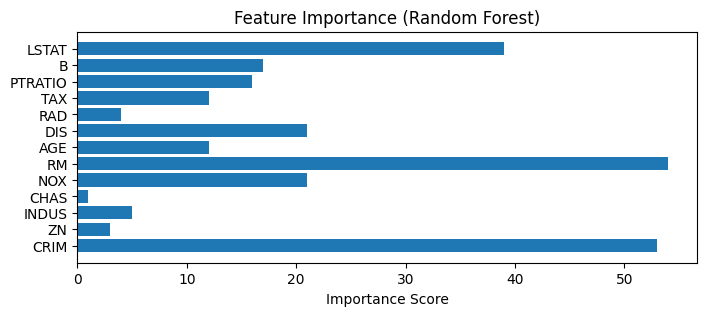

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.barh(features, scores)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()